In [1]:
using JuMP, NamedArrays

In [2]:
# Create a plot showing the request with the time window
function plot_Request_Time_Window(passengers)
    figure();
    request_no = length(passengers)
    drop_time_list = []

    for i=1:request_no
        p = passengers[i]
        drop_time = p.pickup_time+p.duration
        push!(drop_time_list, drop_time)
        
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        hlines(y=i, xmin=p.pickup_time, xmax=drop_time, color=color_val)
        plot(p.pickup_time, i, marker="o", color=color_val)
        plot(drop_time, i, marker="o", color=color_val)
        
        time_stamp = string("T = ", p.pickup_time)
        text(p.pickup_time, i + 0.1, time_stamp, fontsize=8)
        time_stamp = string("T = ", drop_time)
        text(drop_time, i - 0.2, time_stamp, fontsize=8) 
    end

    PyPlot.yticks(1:request_no)
    ax = gca()
    ax[:set_xlim](passengers[1].pickup_time - 10, maximum(drop_time_list) + 20)
    ax[:set_ylim]([0, request_no + 1])
    title("Request vs Time")
    xlabel("Time")
    ylabel("Request #")
    grid("on")
end

plot_Request_Time_Window (generic function with 1 method)

In [3]:
using PyPlot
WIDTH = 51 # odd number
HEIGHT = 41 # odd number
NRG = min(WIDTH, HEIGHT)

type Passenger
    pickup_pos::Tuple{Int64, Int64}
    pickup_time::Int
    dropoff_pos::Tuple{Int64, Int64}
    duration::Int
end
type Driver
    cur_pos::Tuple{Int64, Int64}
end

function manhattan_distance(a, b)
    return sum(abs.([i for i in a]-[i for i in b]))
end

function rand_xy()
   return (rand(1:WIDTH), rand(1:HEIGHT)) 
end


function rand_normalized_xy()
    pass_x = Int(round((randn()/6+0.5)*(NRG-1)+1))
    pass_y = Int(round((randn()/6+0.5)*(NRG-1)+1))
    if WIDTH > HEIGHT
        pass_x += Int(round((WIDTH-HEIGHT)/2))
    else
        pass_y += Int(round((HEIGHT-WIDTH)/2))
    end
    return (pass_x, pass_y)
end


rand_normalized_xy (generic function with 1 method)

In [4]:
function plot_passenger_driver(passengers, drivers)
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[] # driver current position x
    dys = Int64[] # driver current position y
    fig = figure("pyplot_scatterplot",figsize=(15,15) )#(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(passengers)
        p = passengers[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.3)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.3)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(drivers)
        d = drivers[i]
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="r")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="g")
    scatter(dxs,dys,s=300,alpha=0.5,color="b")
    
    title("Map")
    xlabel("X");xlim([1,WIDTH])
    ylabel("Y");ylim([1,HEIGHT])
    grid("on")
end


plot_passenger_driver (generic function with 1 method)

In [5]:
function genGrid(n_passenger, n_driver)
    passengers = Passenger[]
    drivers = Driver[]
    ptime = sort(rand(50:200,n_passenger))
    for i=1:n_passenger
        ppos = rand_xy()
        dpos = rand_xy()
        p = Passenger(ppos, ptime[i], dpos, manhattan_distance(ppos,dpos))
        push!(passengers, p)
    end
    for i=1:n_driver
        d = Driver((Int((WIDTH+1)/2), Int((HEIGHT+1)/2)))
        push!(drivers, d)
    end
    plot_passenger_driver(passengers, drivers)
    for p in passengers
        println(p)
    end
    plot_Request_Time_Window(passengers)
    return passengers,drivers
end

genGrid (generic function with 1 method)

In [7]:
# Function to Get the coordinates of all depot and pickup, drop locations of requests (in order of request)
# Can be modified to be called within distance matrix

function getLocations(depot, requests)
    nodes = []
    for d in depot             # Right now, considering only single depot.
        depot_node = d.cur_pos
        push!(nodes, depot_node)
    end

    for r in requests
        push!(nodes, r.pickup_pos)
        push!(nodes, r.dropoff_pos)
    end
    return nodes
end

getLocations (generic function with 1 method)

# Generating distance matrix 

In [9]:
# Generating distance matrix.
 
function distance_matrix(nodes, numReq)
    
    # Creating names for nodes
    numReq = length(requests)
    points = []
    i = 0
    push!(points,"Depot")
    for r in 1:numReq
        i = i+1
        pickup = string("P_",i)
        drop = string("D_",i)
        push!(points,pickup)
        push!(points,drop)
    end
    println(points)

    # Compute distance matrix for the Agencies
    pointA = nodes
    pointB = copy(nodes)

    nodeLen = length(nodes) # nodes include pickup, dropoff and depot

    D = zeros(nodeLen,nodeLen)

    for j = 1:nodeLen
            for i = 1:nodeLen
                D[i, j] = abs(pointA[j][1] - pointB[i][1]) + abs(pointA[j][2] - pointB[i][2])
            end
    end
    #println("Distance matrix : ",D)
    println("")

    dist_matrix =  NamedArray(D,(points,points),("From","To"))
    show(IOContext(STDOUT, displaysize=(2000, 2000)), dist_matrix)
    points
    return dist_matrix
end

distance_matrix (generic function with 1 method)

In [265]:
function plot_car_route(passengers, drivers, x_request_to_cab)
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[] # driver current position x
    dys = Int64[] # driver current position y
    fig = figure("pyplot_scatterplot",figsize=(15,15) )#(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(passengers)
        p = passengers[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.3)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.3)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(drivers)
        d = drivers[i]
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="r")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="g")
    scatter(dxs,dys,s=300,alpha=0.5,color="b")
    
    # Plost route line for each cab
    for k = 1:K
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        for r = 1:R
            if x_request_to_cab[r, k] > 0
                request = passengers[r]
                
                pp_x = request.pickup_pos[1]
                pp_y = request.pickup_pos[2]
                dp_x = request.dropoff_pos[1]
                dp_y = request.dropoff_pos[2]
                hlines(y=pp_y, xmin=pp_x, xmax=dp_x, color=color_val)
                vlines(x=dp_x, ymin=pp_y, ymax=dp_y, color=color_val)
                
                time_stamp = string("[Cab #", k, "]")
                if dp_y > pp_y
                    plot(dp_x, dp_y, marker="^", color=color_val, markersize = 20)
                    text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                elseif dp_y < pp_y
                    plot(dp_x, dp_y, marker="v", color=color_val, markersize = 20)
                    text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                elseif dp_y == pp_y && dp_x < pp_x
                    plot(dp_x, dp_y, marker="<", color=color_val, markersize = 20)
                    text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                elseif dp_y == pp_y && dp_x > pp_x
                    plot(dp_x, dp_y, marker=">", color=color_val, markersize = 20)
                    text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                end
            end
        end
    end
    
    title("Map")
    xlabel("X");xlim([1,WIDTH])
    ylabel("Y");ylim([1,HEIGHT])
    grid("on")
end

plot_car_route (generic function with 2 methods)

# VRP Model Test

Passenger((34, 17), 52, (11, 36), 42)
Passenger((30, 22), 103, (37, 34), 19)
Passenger((33, 22), 105, (17, 26), 20)
Passenger((44, 26), 114, (37, 30), 11)
Passenger((18, 35), 180, (36, 35), 18)
Any

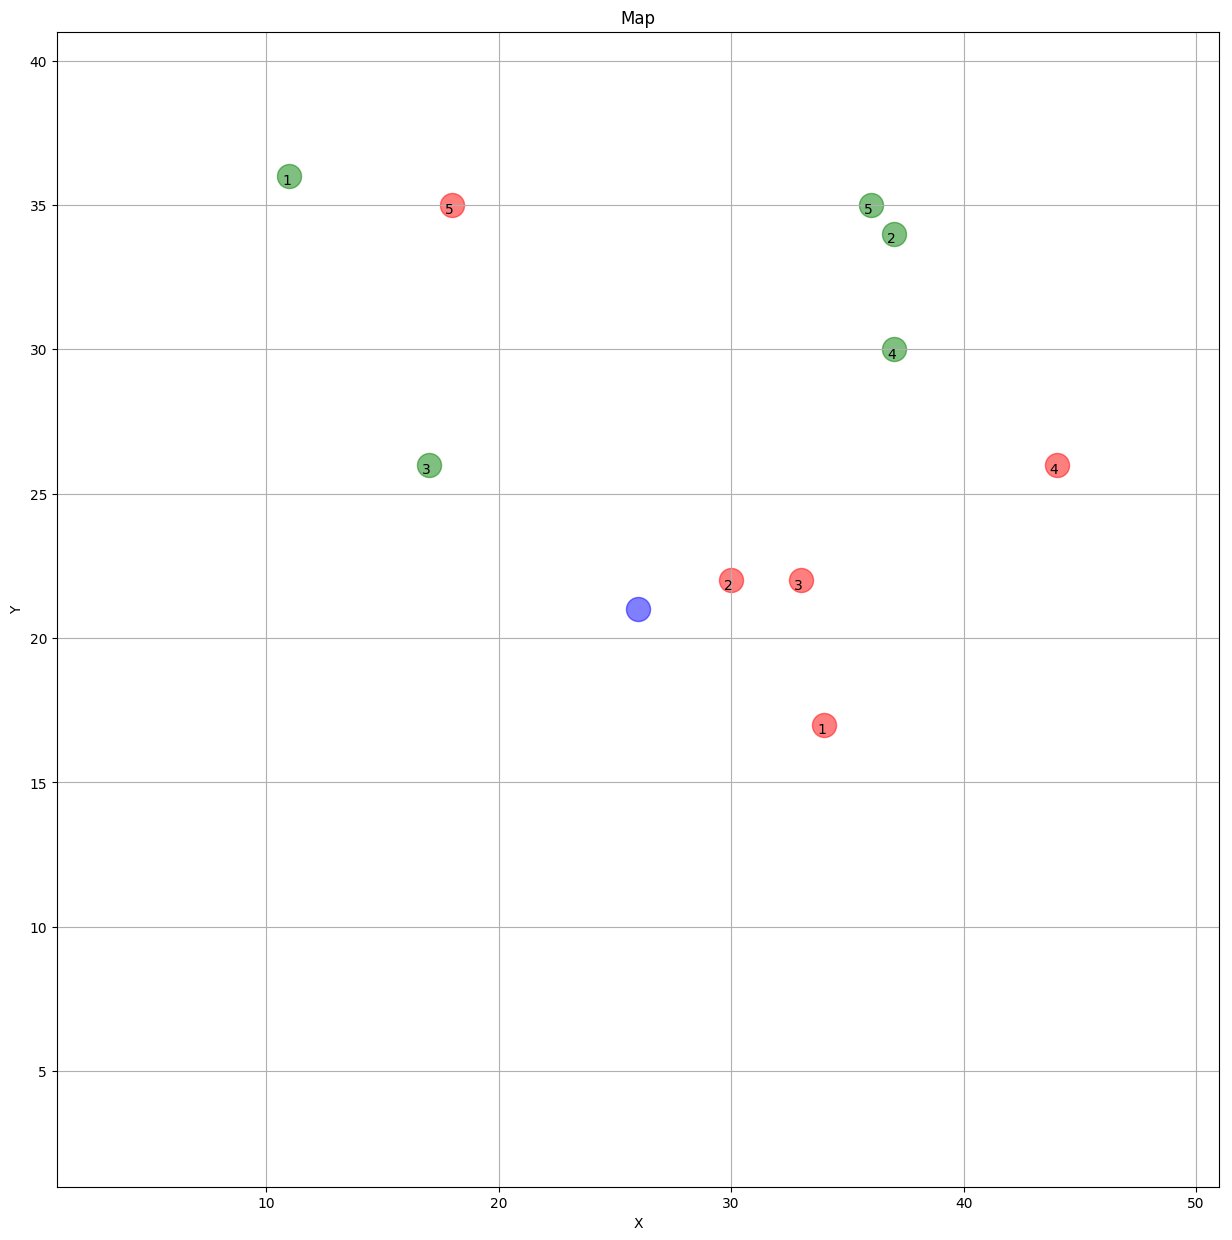

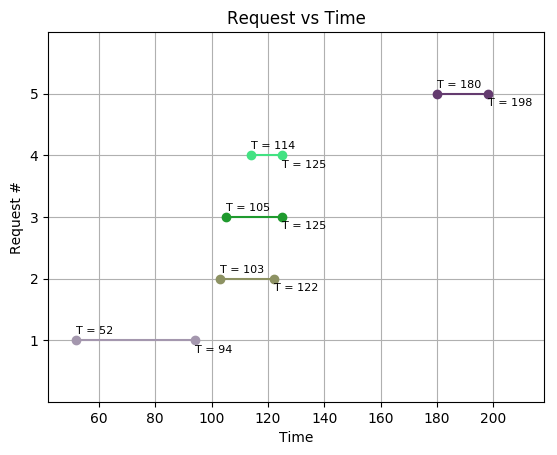

["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3", "P_4", "D_4", "P_5", "D_5"]

11×11 Named Array{Float64,2}
From ╲ To │ Depot    P_1    D_1    P_2    D_2    P_3    D_3    P_4    D_4    P_5    D_5
──────────┼────────────────────────────────────────────────────────────────────────────
Depot     │   0.0   12.0   30.0    5.0   24.0    8.0   14.0   23.0   20.0   22.0   24.0
P_1       │  12.0    0.0   42.0    9.0   20.0    6.0   26.0   19.0   16.0   34.0   20.0
D_1       │  30.0   42.0    0.0   33.0   28.0   36.0   16.0   43.0   32.0    8.0   26.0
P_2       │   5.0    9.0   33.0    0.0   19.0    3.0   17.0   18.0   15.0   25.0   19.0
D_2       │  24.0   20.0   28.0   19.0    0.0   16.0   28.0   15.0    4.0   20.0    2.0
P_3       │   8.0    6.0   36.0    3.0   16.0    0.0   20.0   15.0   12.0   28.0   16.0
D_3       │  14.0   26.0   16.0   17.0   28.0   20.0    0.0   27.0   24.0   10.0   28.0
P_4       │  23.0   19.0   43.0   18.0   15.0   15.0   27.0    0.0   11.0   35.0   17.0
D_4       

In [260]:
# Parameter
R = 5
requests, depot = genGrid(R, 1)
nodes = getLocations(depot, requests)
dist_map = distance_matrix(nodes, length(requests));

p_t = []
p_l = []
d_t = []
d_l = []
duration = []

println("")
for r = 1:R
    println(requests[r])
    push!(p_t, requests[r].pickup_time)
    push!(p_l, requests[r].pickup_pos)
    push!(d_t, requests[r].pickup_time + requests[r].duration)
    push!(d_l, requests[r].dropoff_pos)
    push!(duration, requests[r].duration)
end

println("")
println("pickup time = ", p_t)
println("pickup location = ", p_l)
println("dropoff time = ", d_t)
println("dropoff location = ", d_l)
println("duration = ", duration)

In [261]:
K = 5
small_m = minimum(p_t) - maximum(d_t) - maximum(dist_map)
println("small_m = ", small_m)
Big_M = sum(dist_map)
println("Big_M = ", Big_M)
epsilon = 1
small_m2 = 0
small_m3 = -1
lambda = 100

using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, y[1:K], Bin)
@variable(m, x[1:R, 1:K], Bin)
@variable(m, mask[1:2R+1, 1:2R+1, 1:K], Bin)
@expression(m, d[k in 1:K], sum(dist_map[p, d] * mask[p, d, k] for p in 1:2R+1, d in 1:2R+1))

@constraint(m, constraint1[r in 1:R], sum(x[r, k] for k =1:K) == 1)

for r = 1:R
    for k = 1:K
        @constraint(m, mask[2r, 2r+1, k] - 1 >= small_m3*(1 - x[r, k]))
    end
end

for k = 1:K
    @constraint(m, d[k] <= Big_M * y[k])
    @constraint(m, d[k] >= small_m2 * (1 - y[k]) + epsilon*y[k])
end

for r1 = 1:R-1
    for r2 = (r1+1):R
        for k = 1:K
            @constraint(m, p_t[r2] - d_t[r1] - dist_map[2*r2, 2*r1+1] >= small_m*(1 - x[r1, k]*x[r2, k]))
            @constraint(m, mask[2*r1+1, 2*r2, k] - 1 >= small_m3*(1 - x[r1, k]*x[r2, k]))
        end
    end
end

for p_idx in 1:2R+1
    for d_idx in 1:2R+1
        @constraint(m, sum(mask[p_idx, d_idx, k] for k in 1:K) <= 1)
    end
end

@objective(m, Min, sum(lambda*y + d))

status = solve(m)

#println(m)
println(status)
println("Optimum = ", getobjectivevalue(m))
println("y = ", getvalue(y))

println("x = ")
for r = 1:R
    println(getvalue(x)[r, 1:K])
end

println("mask = ")
mask_best = getvalue(mask)
for k = 1:K
    for p_idx in 1:2R+1
        println(mask_best[p_idx, 1:2R+1, k])
    end
    println("")
end
println("d = ", getvalue(d))

small_m = -189.0
Big_M = 2176.0
Academic license - for non-commercial use only
Optimal
Optimum = 518.0
y = [0.0, 1.0, 1.0, 1.0, 1.0]
x = 
[-0.0, -0.0, -0.0, -0.0, 1.0]
[-0.0, 1.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, 1.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, 1.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, 1.0]
mask = 
[0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0

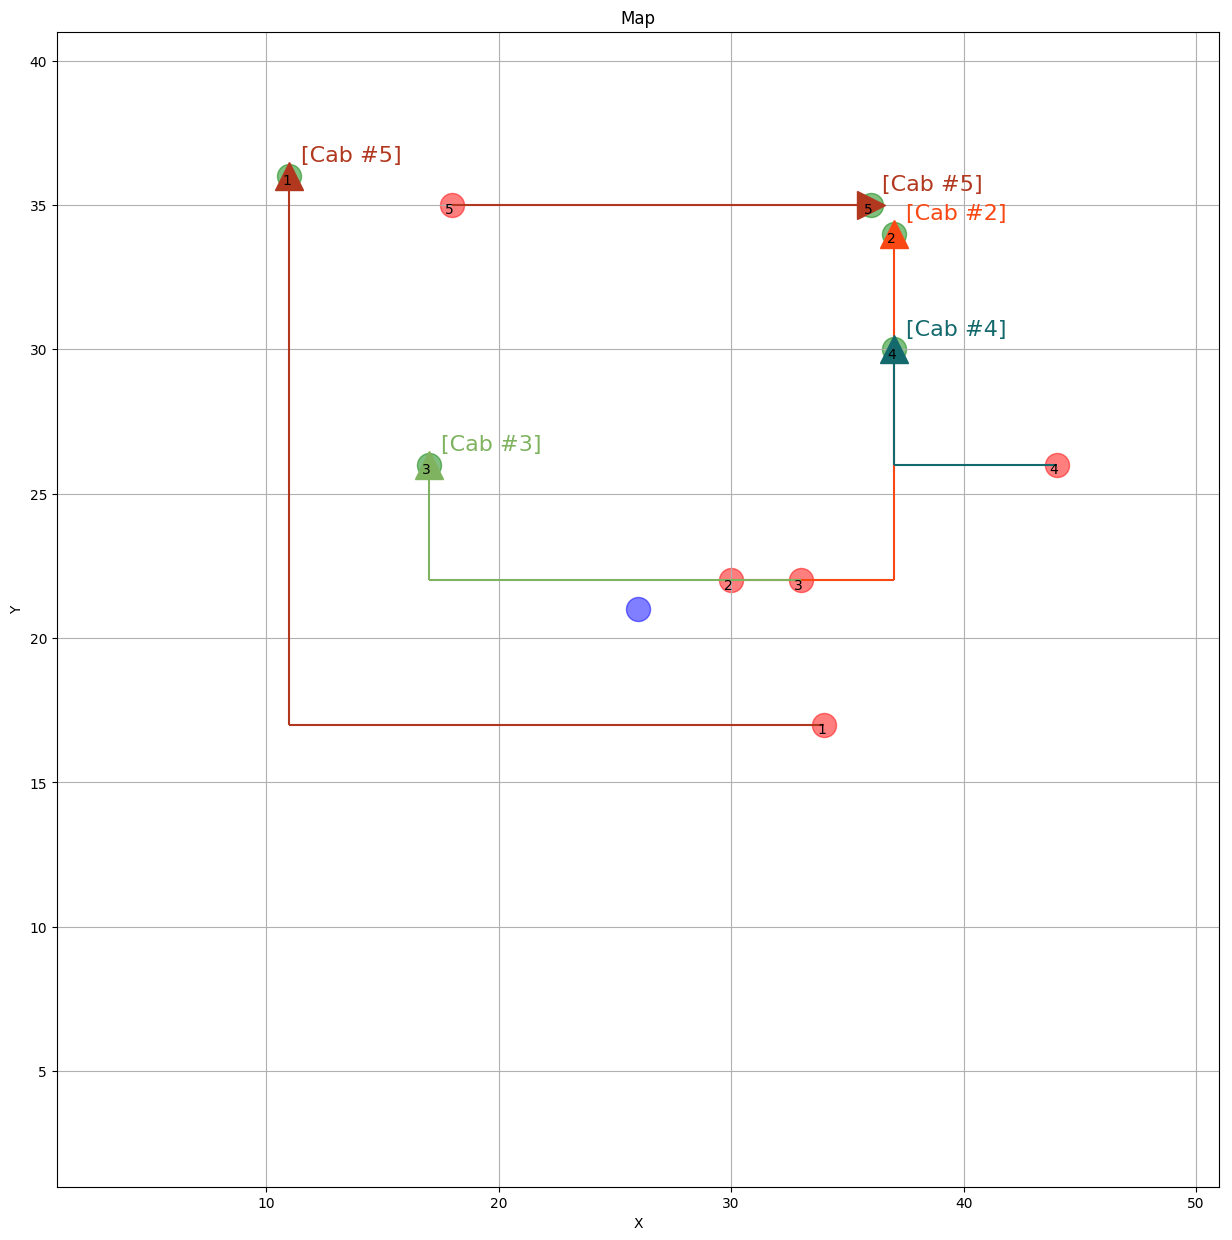

In [266]:
plot_car_route(requests, depot, getvalue(x))